<a href="https://colab.research.google.com/github/Saramando/263F/blob/main/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discrete Elastic Rods
Copyright M. Khalid Jawed (khalidjm@seas.ucla.edu). License: CC BY-NC
You should use this code at your own risk.

#Load Libraries

In [115]:
!pip install import-ipynb --quiet

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

#Miscellaneous Functions: signedAngle, rotateAxisAngle, parallel_transport, crossMat

In [117]:
def signedAngle(u = None,v = None,n = None):
    # This function calculates the signed angle between two vectors, "u" and "v",
    # using an optional axis vector "n" to determine the direction of the angle.
    #
    # Parameters:
    #   u: numpy array-like, shape (3,), the first vector.
    #   v: numpy array-like, shape (3,), the second vector.
    #   n: numpy array-like, shape (3,), the axis vector that defines the plane
    #      in which the angle is measured. It determines the sign of the angle.
    #
    # Returns:
    #   angle: float, the signed angle (in radians) from vector "u" to vector "v".
    #          The angle is positive if the rotation from "u" to "v" follows
    #          the right-hand rule with respect to the axis "n", and negative otherwise.
    #
    # The function works by:
    # 1. Computing the cross product "w" of "u" and "v" to find the vector orthogonal
    #    to both "u" and "v".
    # 2. Calculating the angle between "u" and "v" using the arctan2 function, which
    #    returns the angle based on the norm of "w" (magnitude of the cross product)
    #    and the dot product of "u" and "v".
    # 3. Using the dot product of "n" and "w" to determine the sign of the angle.
    #    If this dot product is negative, the angle is adjusted to be negative.
    #
    # Example:
    #   signedAngle(np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]))
    #   This would return a positive angle (π/2 radians), as the rotation
    #   from the x-axis to the y-axis is counterclockwise when viewed along the z-axis.
    w = np.cross(u,v)
    angle = np.arctan2( np.linalg.norm(w), np.dot(u,v) )
    if (np.dot(n,w) < 0):
        angle = - angle

    return angle

In [118]:
def test_signedAngle():
  """
  This function tests the signedAngle function with three test cases.
  """
  # Test case 1: Orthogonal vectors
  u = np.array([1, 0, 0])
  v = np.array([0, 1, 0])
  n = np.array([0, 0, 1])
  angle = signedAngle(u, v, n)
  assert np.isclose(angle, np.pi/2), "Test case 1 failed"

  # Test case 2: Parallel vectors
  u = np.array([1, 1, 1])
  v = np.array([2, 2, 2])
  n = np.array([0, 1, 0])
  angle = signedAngle(u, v, n)
  assert np.isclose(angle, 0), "Test case 2 failed"

  # Test case 3: Anti-parallel vectors
  u = np.array([1, 1, 1])
  v = np.array([-1, -1, -1])
  n = np.array([0, 1, 0])
  angle = signedAngle(u, v, n)
  assert np.isclose(angle, np.pi), "Test case 3 failed"

  print("All test cases passed")

test_signedAngle()

All test cases passed


In [119]:
def rotateAxisAngle(v = None,z = None,theta = None):
    # This function rotates a vector "v" around a specified axis "z" by an angle "theta".
    #
    # Parameters:
    #   v: numpy array-like, shape (3,), the vector to be rotated.
    #   z: numpy array-like, shape (3,), the unit vector representing the axis of rotation.
    #      It should be normalized before calling the function for correct results.
    #   theta: float, the rotation angle in radians.
    #
    # Returns:
    #   vNew: numpy array-like, shape (3,), the rotated vector after applying the rotation
    #         around axis "z" by angle "theta".
    #
    # The function works by:
    # 1. Checking if the rotation angle "theta" is zero. If so, the function returns the original
    #    vector "v" unchanged since no rotation is needed.
    # 2. If "theta" is not zero, it computes the new rotated vector using the formula:
    #      vNew = cos(theta) * v + sin(theta) * (z × v) + (1 - cos(theta)) * (z · v) * z
    #    This formula is derived from Rodrigues' rotation formula, which calculates the rotation
    #    of a vector around an axis using trigonometric functions and vector operations.
    #    - The term cos(theta) * v represents the component of "v" that remains aligned with "v".
    #    - The term sin(theta) * (z × v) gives the component perpendicular to both "z" and "v".
    #    - The term (1 - cos(theta)) * (z · v) * z adjusts the result based on the projection of "v"
    #      onto the axis "z".
    #
    # Example:
    #   rotateAxisAngle(np.array([1, 0, 0]), np.array([0, 0, 1]), np.pi/2)
    #   This would rotate the vector [1, 0, 0] by 90 degrees around the z-axis, returning
    #   a vector close to [0, 1, 0].
    if (theta == 0):
        vNew = v
    else:
        c = np.cos(theta)
        s = np.sin(theta)
        vNew = c * v + s * np.cross(z,v) + np.dot(z,v) * (1.0 - c) * z

    return vNew

In [120]:
def test_rotateAxisAngle():
  """
  This function tests the rotateAxisAngle function by comparing the output with
  the expected output for a given set of inputs.
  """

  # Test case: Rotate a vector by 90 degrees around the z-axis
  v = np.array([1, 0, 0])
  axis = np.array([0, 0, 1])
  theta = np.pi/2
  v_rotated = rotateAxisAngle(v, axis, theta)

  # Expected output
  v_expected = np.array([0, 1, 0])

  # Check if the output is close to the expected output
  assert np.allclose(v_rotated, v_expected), "Test case failed"

  print("Test case passed")

test_rotateAxisAngle()

Test case passed


In [121]:
def parallel_transport(u = None,t1 = None,t2 = None):

    # This function parallel transports a vector u from tangent t1 to t2
    # Input:
    # t1 - vector denoting the first tangent
    # t2 - vector denoting the second tangent
    # u - vector that needs to be parallel transported
    # Output:
    # d - vector after parallel transport

    b = np.cross(t1,t2)
    if (np.linalg.norm(b) == 0):
        d = u
    else:
        b = b / np.linalg.norm(b)
        # The following four lines may seem unnecessary but can sometimes help
        # with numerical stability
        b = b - np.dot(b,t1) * t1
        b = b / np.linalg.norm(b)
        b = b - np.dot(b,t2) * t2
        b = b / np.linalg.norm(b)
        n1 = np.cross(t1,b)
        n2 = np.cross(t2,b)
        d = np.dot(u,t1) * t2 + np.dot(u,n1) * n2 + np.dot(u,b) * b

    return d

In [122]:
def test_parallel_transport():
  """
  This function tests the parallel_transport function by checking if the
  transported vector is orthogonal to the new tangent vector.
  """

  # Test case 1: Orthogonal tangents
  u = np.array([1, 0, 0])
  t1 = np.array([0, 1, 0])
  t2 = np.array([0, 0, 1])
  u_transported = parallel_transport(u, t1, t2)
  assert np.allclose(np.dot(u_transported, t2), 0), "Test case 1 failed"
  # Returns True if two arrays are element-wise equal within a tolerance.

  # Test case 2: Parallel tangents
  u = np.array([1, 1, 1])
  t1 = np.array([1, 0, 0])
  t2 = np.array([2, 0, 0])
  u_transported = parallel_transport(u, t1, t2)
  assert np.allclose(u_transported, u), "Test case 2 failed"

  print("All test cases passed")

test_parallel_transport()

All test cases passed


In [123]:
def crossMat(a):
    A=np.matrix([[0,- a[2],a[1]],[a[2],0,- a[0]],[- a[1],a[0],0]])
    return A

#Functions to calculate tangent, material frame, and reference frame (by time parallel transport)

In [124]:
def computeTangent(q):
  ne = int((len(q)+1)/4 - 1)
  tangent = np.zeros((ne, 3))
  for c in range(ne):
    dx = q[4*c+4:4*c+7] - q[4*c:4*c+3] # edge vector
    tangent[c,:] = dx / np.linalg.norm(dx) # make it unit
  return tangent

In [125]:
def computeSpaceParallel(d1_first, q):
  ne = int((len(q)+1)/4 - 1)
  tangent = computeTangent(q)

  d1 = np.zeros((ne, 3))
  d2 = np.zeros((ne, 3))

  # First edge
  d1[0,:] = d1_first # Given
  t0 = tangent[0,:] # Tangent on first edge
  d2[0,:] = np.cross(t0, d1_first)

  # Parallel transport from previous edge to the next
  for c in range(1, ne):
    t = tangent[c,:]
    d1_first = parallel_transport(d1_first, t0, t)
    # d1_first should be perpendicular to t
    d1_first = d1_first - np.dot(d1_first, t) * t
    d1_first = d1_first / np.linalg.norm(d1_first)

    # Store d1 and d2 vectors for c-th edge
    d1[c,:] = d1_first
    d2[c,:] = np.cross(t, d1_first) # I made a mistake in class and wrote cross(t0, d1_first)

    t0 = t.copy() # New tangent now becomes old tangent
    # I made a mistake in class and forgot to write "t.copy()" and just wrote "t0=t"

  return d1, d2

In [126]:
def computeMaterialFrame(a1, a2, theta):
  ne = len(theta)
  m1 = np.zeros((ne, 3))
  m2 = np.zeros((ne, 3))
  for c in range(ne): # loop over every edge
    m1[c,:] = a1[c,:] * np.cos(theta[c]) + a2[c,:] * np.sin(theta[c])
    m2[c,:] = - a1[c,:] * np.sin(theta[c]) + a2[c,:] * np.cos(theta[c])
  return m1, m2

In [127]:
def computeTimeParallel(a1_old, q0, q):
  # a1_old is (ne,3) ndarray representing old reference frame
  # q0 is the old DOF vector from where reference frame should be transported
  # q is the new DOF vector where reference frame should be transported to
  ne = int((len(q)+1)/4 - 1)
  tangent0 = computeTangent(q0) # Old tangents
  tangent = computeTangent(q) # New tangents

  a1 = np.zeros((ne, 3))
  a2 = np.zeros((ne, 3))
  for c in range(ne):
    t0 = tangent0[c,:]
    t = tangent[c,:]
    a1_tmp = parallel_transport(a1_old[c,:], t0, t)
    a1[c,:] = a1_tmp - np.dot(a1_tmp, t) * t
    a1[c,:] = a1[c,:] / np.linalg.norm(a1[c,:])
    a2[c,:] = np.cross(t, a1[c,:])

  return a1, a2

#Functions to calculate reference twist and curvature

In [128]:
def computeReferenceTwist(u1, u2, t1, t2, refTwist = None):
    # This function computes the reference twist angle between two vectors "u1" and "u2",
    # given two tangent directions "t1" and "t2", and an optional initial guess for the twist.
    # It adjusts the guess to align "u1" with "u2" when parallel transported along "t1" and "t2".
    #
    # Parameters:
    #   u1: numpy array-like, shape (3,), the initial vector at position "t1".
    #   u2: numpy array-like, shape (3,), the target vector at position "t2".
    #   t1: numpy array-like, shape (3,), the initial tangent direction.
    #   t2: numpy array-like, shape (3,), the target tangent direction.
    #   refTwist: float, an optional initial guess for the reference twist angle (in radians).
    #             If not provided, it defaults to zero.
    #
    # Returns:
    #   refTwist: float, the adjusted reference twist angle (in radians) that aligns "u1"
    #             with "u2" after parallel transport and rotation.
    #
    # The function works by:
    # 1. Checking if "refTwist" is None and setting it to zero if no initial guess is provided.
    #    This ensures a default starting point for the twist calculation.
    # 2. Parallel transporting "u1" along "t1" to "t2" using the parallel_transport function.
    #    This adjusts "u1" so that it is aligned correctly in the direction of "t2".
    # 3. Rotating the parallel transported vector "ut" around "t2" by the current "refTwist" angle
    #    using the rotateAxisAngle function. This accounts for the initial twist guess.
    # 4. Computing the angle between the rotated "ut" and "u2" using the signedAngle function,
    #    with "t2" as the axis to determine the direction of the angle.
    # 5. Adjusting "refTwist" by adding the signed angle, thus refining the twist angle to
    #    align "u1" with "u2" after transport and rotation.
    #
    # Example:
    #   computeReferenceTwist(np.array([1, 0, 0]), np.array([0, 1, 0]),
    #                         np.array([0, 0, 1]), np.array([0, 0, 1]))
    #   This would compute the reference twist needed to align the x-axis with the y-axis
    #   after transporting along the same tangent direction, starting with an initial guess of 0.
    if refTwist is None:
      refTwist = 0
    ut = parallel_transport(u1, t1, t2)
    ut = rotateAxisAngle(ut, t2, refTwist)
    refTwist = refTwist + signedAngle(ut, u2, t2)
    return refTwist

In [129]:
def computekappa(node0, node1, node2, m1e, m2e, m1f, m2f):
    # This function computes the curvature "kappa" at a "turning" node in a discrete elastic rod model.
    # The curvature is calculated using the positions of three consecutive nodes and the material
    # directors of the edges before and after the turning point.
    #
    # Parameters:
    #   node0: array-like, shape (3,), the position of the node before the turning node.
    #          This represents the node before the bend in the rod.
    #   node1: array-like, shape (3,), the position of the "turning" node.
    #          This node is the point around which the curvature is calculated.
    #   node2: array-like, shape (3,), the position of the node after the turning node.
    #          This represents the node after the bend in the rod.
    #   m1e: array-like, shape (3,), material director 1 of the edge before the turning point.
    #        This is a vector that defines one direction in the material frame of the edge before turning.
    #   m2e: array-like, shape (3,), material director 2 of the edge before the turning point.
    #        This is a vector orthogonal to m1e in the material frame of the edge before turning.
    #   m1f: array-like, shape (3,), material director 1 of the edge after the turning point.
    #        This is a vector that defines one direction in the material frame of the edge after turning.
    #   m2f: array-like, shape (3,), material director 2 of the edge after the turning point.
    #        This is a vector orthogonal to m1f in the material frame of the edge after turning.
    #
    # Returns:
    #   kappa: array-like, shape (2,), the computed curvature at the turning node.
    #          - kappa[0]: Curvature component in the direction of the second material director.
    #          - kappa[1]: Curvature component in the direction of the first material director.
    #
    # The function works by:
    # 1. Computing the tangent vectors "t0" and "t1" for the edges before and after the turning node.
    #    - "t0" is the normalized vector from "node0" to "node1".
    #    - "t1" is the normalized vector from "node1" to "node2".
    # 2. Calculating the "curvature binormal" vector "kb", which measures the change in direction between
    #    "t0" and "t1". The formula ensures that the curvature is properly scaled and oriented.
    # 3. Initializing a "kappa" array to store the curvature components.
    # 4. Calculating "kappa1", which is proportional to the projection of "kb" onto the average of
    #    the material director "m2" vectors before and after the turning point.
    # 5. Calculating "kappa2", which is proportional to the negative projection of "kb" onto the average of
    #    the material director "m1" vectors before and after the turning point.
    # 6. Storing "kappa1" and "kappa2" in the "kappa" array and returning it.
    #
    # This function is crucial in simulating the bending behavior of a discrete elastic rod,
    # where the curvature at each turning point determines how the rod deforms. The use of
    # material directors allows for accurate representation of the bending directions in
    # the material frame.
    #
    # Example:
    #   computekappa(node0, node1, node2, m1e, m2e, m1f, m2f)
    #   This would compute the curvature for a given set of node positions and material directors.

    t0 = (node1 - node0) / np.linalg.norm(node1 - node0)
    t1 = (node2 - node1) / np.linalg.norm(node2 - node1)

    kb = 2.0 * np.cross(t0,t1) / (1.0 + np.dot(t0,t1))
    kappa1 = 0.5 * np.dot(kb,m2e + m2f)
    kappa2 = - 0.5 * np.dot(kb,m1e + m1f)

    kappa = np.zeros(2)
    kappa[0] = kappa1
    kappa[1] = kappa2

    return kappa

In [130]:
def getRefTwist(a1, tangent, refTwist):
  ne = a1.shape[0] # Shape of a1 is (ne,3)
  for c in np.arange(1,ne):
    u0 = a1[c-1,0:3] # reference frame vector of previous edge
    u1 = a1[c,0:3] # reference frame vector of current edge
    t0 = tangent[c-1,0:3] # tangent of previous edge
    t1 = tangent[c,0:3] # tangent of current edge
    refTwist[c] = computeReferenceTwist(u0, u1, t0, t1, refTwist[c])
  return refTwist

In [131]:
def getKappa(q0, m1, m2):
  ne = m1.shape[0] # Shape of m1 is (ne,3)
  nv = ne + 1

  kappa = np.zeros((nv,2))

  for c in np.arange(1,ne):
    node0 = q0[4*c-4:4*c-1]
    node1 = q0[4*c+0:4*c+3]
    node2 = q0[4*c+4:4*c+7]

    m1e = m1[c-1,0:3].flatten() # Material frame of previous edge
    m2e = m2[c-1,0:3].flatten() # NOT SURE if flattening is needed or not
    m1f = m1[c,0:3].flatten() # Material frame of current edge
    m2f = m2[c,0:3].flatten()

    kappa_local = computekappa(node0, node1, node2, m1e, m2e, m1f, m2f)

    # Store the values
    kappa[c,0] = kappa_local[0]
    kappa[c,1] = kappa_local[1]

  return kappa

# Gradients and Hessians of Elastic Energies

In [132]:
def gradEs_hessEs(node0 = None,node1 = None,l_k = None,EA = None):

# Inputs:
# node0: 1x3 vector - position of the first node
# node1: 1x3 vector - position of the last node

# l_k: reference length (undeformed) of the edge
# EA: scalar - stretching stiffness - Young's modulus times area

# Outputs:
# dF: 6x1  vector - gradient of the stretching energy between node0 and node 1.
# dJ: 6x6 vector - hessian of the stretching energy between node0 and node 1.

    ## Gradient of Es
    edge = node1 - node0

    edgeLen = np.linalg.norm(edge)
    tangent = edge / edgeLen
    epsX = edgeLen / l_k - 1
    dF_unit = EA * tangent * epsX
    dF = np.zeros((6))
    dF[0:3] = - dF_unit
    dF[3:6] = dF_unit

    ## Hessian of Es
    Id3 = np.eye(3)
    M = EA * ((1 / l_k - 1 / edgeLen) * Id3 + 1 / edgeLen * ( np.outer( edge, edge ) ) / edgeLen ** 2)

    dJ = np.zeros((6,6))
    dJ[0:3,0:3] = M
    dJ[3:6,3:6] = M
    dJ[0:3,3:6] = - M
    dJ[3:6,0:3] = - M
    return dF,dJ

In [133]:
def gradEb_hessEb(node0 = None,node1 = None,node2 = None,m1e = None,m2e = None,m1f = None,m2f = None,kappaBar = None,l_k = None, EI1 = None, EI2 = None):

# This function follows the formulation by Panetta et al. 2019

# Inputs:
# node0: 1x3 vector - position of the node prior to the "turning" node
# node1: 1x3 vector - position of the "turning" node
# node2: 1x3 vector - position of the node after the "turning" node

# m1e: 1x3 vector - material director 1 of the edge prior to turning
# m2e: 1x3 vector - material director 2 of the edge prior to turning
# m1f: 1x3 vector - material director 1 of the edge after turning
# m2f: 1x3 vector - material director 2 of the edge after turning

# kappaBar: 1x2 vector - natural curvature at the turning node
# l_k: voronoi length (undeformed) of the turning node
# EI1: scalar - bending stiffness for kappa1
# EI2: scalar - bending stiffness for kappa2

# Outputs:
# dF: 11x1  vector - gradient of the bending energy at node1.
# dJ: 11x11 vector - hessian of the bending energy at node1.

    # If EI2 is not specified, set it equal to EI1
    if EI2 == None:
        EI2 = EI1

    #
    ## Computation of gradient of the two curvatures
    #
    gradKappa = np.zeros((11,2))

    ee = node1 - node0
    ef = node2 - node1
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te,tf) / (1.0 + np.dot(te,tf))
    chi = 1.0 + np.dot(te,tf)
    tilde_t = (te + tf) / chi
    tilde_d1 = (m1e + m1f) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvatures
    kappa1 = 0.5 * np.dot(kb,m2e + m2f)
    kappa2 = - 0.5 * np.dot(kb,m1e + m1f)

    Dkappa1De = 1.0 / norm_e * (- kappa1 * tilde_t + np.cross(tf,tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (- kappa1 * tilde_t - np.cross(te,tilde_d2))
    Dkappa2De = 1.0 / norm_e * (- kappa2 * tilde_t - np.cross(tf,tilde_d1))
    Dkappa2Df = 1.0 / norm_f * (- kappa2 * tilde_t + np.cross(te,tilde_d1))
    gradKappa[0:3,1-1] = - Dkappa1De
    gradKappa[4:7,1-1] = Dkappa1De - Dkappa1Df
    gradKappa[8:11,1-1] = Dkappa1Df
    gradKappa[0:3,2-1] = - Dkappa2De
    gradKappa[4:7,2-1] = Dkappa2De - Dkappa2Df
    gradKappa[8:11,2-1] = Dkappa2Df
    gradKappa[4-1,1-1] = - 0.5 * np.dot(kb,m1e)
    gradKappa[8-1,1-1] = - 0.5 * np.dot(kb,m1f)
    gradKappa[4-1,2-1] = - 0.5 * np.dot(kb,m2e)
    gradKappa[8-1,2-1] = - 0.5 * np.dot(kb,m2f)

    #
    ## Computation of hessian of the two curvatures
    #
    DDkappa1 = np.zeros((11,11)) # Hessian of kappa1
    DDkappa2 = np.zeros((11,11)) # Hessian of kappa2

    norm2_e = norm_e ** 2
    norm2_f = norm_f ** 2

    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf,tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_tf_c_d2t = np.transpose(tf_c_d2t_o_tt)
    kb_o_d2e = np.outer(kb, m2e)
    d2e_o_kb = np.transpose(kb_o_d2e) # Not used in Panetta 2019
    te_o_te = np.outer(te, te)
    Id3 = np.eye(3)

    # Bergou 2010
    # D2kappa1De2 = 1.0 / norm2_e * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tt_o_tf_c_d2t) - kappa1 / (chi * norm2_e) * (Id3 - te_o_te ) + 1.0 / (4.0 * norm2_e) * (kb_o_d2e + d2e_o_kb)
    # Panetta 2019
    D2kappa1De2 = 1.0 / norm2_e * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tt_o_tf_c_d2t) - kappa1 / (chi * norm2_e) * (Id3 - te_o_te ) + 1.0 / (2.0 * norm2_e) * (kb_o_d2e)


    tmp = np.cross(te,tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = np.transpose(te_c_d2t_o_tt)
    kb_o_d2f = np.outer(kb, m2f)
    d2f_o_kb = np.transpose(kb_o_d2f) # Not used in Panetta 2019
    tf_o_tf = np.outer( tf, tf )

    # Bergou 2010
    # D2kappa1Df2 = 1.0 / norm2_f * (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + tt_o_te_c_d2t) - kappa1 / (chi * norm2_f) * (Id3 - tf_o_tf) + 1.0 / (4.0 * norm2_f) * (kb_o_d2f + d2f_o_kb)
    # Panetta 2019
    D2kappa1Df2 = 1.0 / norm2_f * (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + tt_o_te_c_d2t) - kappa1 / (chi * norm2_f) * (Id3 - tf_o_tf) + 1.0 / (2.0 * norm2_f) * (kb_o_d2f)


    te_o_tf = np.outer(te, tf)
    D2kappa1DfDe = - kappa1 / (chi * norm_e * norm_f) * (Id3 + te_o_tf) + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DeDf = np.transpose(D2kappa1DfDe)

    tmp = np.cross(tf,tilde_d1)
    tf_c_d1t_o_tt = np.outer(tmp, tilde_t)
    tt_o_tf_c_d1t = np.transpose(tf_c_d1t_o_tt)
    kb_o_d1e = np.outer(kb, m1e)
    d1e_o_kb = np.transpose(kb_o_d1e) # Not used in Panetta 2019

    # Bergou 2010
    # D2kappa2De2 = 1.0 / norm2_e * (2.0 * kappa2 * tt_o_tt + tf_c_d1t_o_tt + tt_o_tf_c_d1t) - kappa2 / (chi * norm2_e) * (Id3 - te_o_te) - 1.0 / (4.0 * norm2_e) * (kb_o_d1e + d1e_o_kb)
    # Panetta 2019
    D2kappa2De2 = 1.0 / norm2_e * (2.0 * kappa2 * tt_o_tt + tf_c_d1t_o_tt + tt_o_tf_c_d1t) - kappa2 / (chi * norm2_e) * (Id3 - te_o_te) - 1.0 / (2.0 * norm2_e) * (kb_o_d1e)

    tmp = np.cross(te,tilde_d1)
    te_c_d1t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d1t = np.transpose(te_c_d1t_o_tt)
    kb_o_d1f = np.outer(kb, m1f)
    d1f_o_kb = np.transpose(kb_o_d1f) # Not used in Panetta 2019

    # Bergou 2010
    # D2kappa2Df2 = 1.0 / norm2_f * (2 * kappa2 * tt_o_tt - te_c_d1t_o_tt - tt_o_te_c_d1t) - kappa2 / (chi * norm2_f) * (Id3 - tf_o_tf) - 1.0 / (4.0 * norm2_f) * (kb_o_d1f + d1f_o_kb)
    # Panetta 2019
    D2kappa2Df2 = 1.0 / norm2_f * (2 * kappa2 * tt_o_tt - te_c_d1t_o_tt - tt_o_te_c_d1t) - kappa2 / (chi * norm2_f) * (Id3 - tf_o_tf) - 1.0 / (2.0 * norm2_f) * (kb_o_d1f)

    D2kappa2DfDe = - kappa2 / (chi * norm_e * norm_f) * (Id3 + te_o_tf) + 1.0 / (norm_e * norm_f) * (2 * kappa2 * tt_o_tt + tf_c_d1t_o_tt - tt_o_te_c_d1t + crossMat(tilde_d1))
    D2kappa2DeDf = np.transpose(D2kappa2DfDe)

    D2kappa1Dthetae2 = - 0.5 * np.dot(kb,m2e)
    D2kappa1Dthetaf2 = - 0.5 * np.dot(kb,m2f)
    D2kappa2Dthetae2 = 0.5 * np.dot(kb,m1e)
    D2kappa2Dthetaf2 = 0.5 * np.dot(kb,m1f)

    D2kappa1DeDthetae = 1.0 / norm_e * (0.5 * np.dot(kb,m1e) * tilde_t - 1.0 / chi * np.cross(tf,m1e))
    D2kappa1DeDthetaf = 1.0 / norm_e * (0.5 * np.dot(kb,m1f) * tilde_t - 1.0 / chi * np.cross(tf,m1f))
    D2kappa1DfDthetae = 1.0 / norm_f * (0.5 * np.dot(kb,m1e) * tilde_t + 1.0 / chi * np.cross(te,m1e))
    D2kappa1DfDthetaf = 1.0 / norm_f * (0.5 * np.dot(kb,m1f) * tilde_t + 1.0 / chi * np.cross(te,m1f))
    D2kappa2DeDthetae = 1.0 / norm_e * (0.5 * np.dot(kb,m2e) * tilde_t - 1.0 / chi * np.cross(tf,m2e))
    D2kappa2DeDthetaf = 1.0 / norm_e * (0.5 * np.dot(kb,m2f) * tilde_t - 1.0 / chi * np.cross(tf,m2f))
    D2kappa2DfDthetae = 1.0 / norm_f * (0.5 * np.dot(kb,m2e) * tilde_t + 1.0 / chi * np.cross(te,m2e))
    D2kappa2DfDthetaf = 1.0 / norm_f * (0.5 * np.dot(kb,m2f) * tilde_t + 1.0 / chi * np.cross(te,m2f))

    # Curvature terms
    DDkappa1[0:3,0:3] = D2kappa1De2
    DDkappa1[0:3,4:7] = - D2kappa1De2 + D2kappa1DfDe
    DDkappa1[0:3,8:11] = - D2kappa1DfDe
    DDkappa1[4:7,0:3] = - D2kappa1De2 + D2kappa1DeDf
    DDkappa1[4:7,4:7] = D2kappa1De2 - D2kappa1DeDf - D2kappa1DfDe + D2kappa1Df2
    DDkappa1[4:7,8:11] = D2kappa1DfDe - D2kappa1Df2
    DDkappa1[8:11,0:3] = - D2kappa1DeDf
    DDkappa1[8:11,4:7] = D2kappa1DeDf - D2kappa1Df2
    DDkappa1[8:11,8:11] = D2kappa1Df2

    # Twist terms
    DDkappa1[4-1,4-1] = D2kappa1Dthetae2
    DDkappa1[8-1,8-1] = D2kappa1Dthetaf2

    # Curvature-twist coupled terms
    DDkappa1[0:3,4-1] = - D2kappa1DeDthetae
    DDkappa1[4:7,4-1] = D2kappa1DeDthetae - D2kappa1DfDthetae
    DDkappa1[8:11,4-1] = D2kappa1DfDthetae
    DDkappa1[4-1,0:3] = np.transpose(DDkappa1[0:3,4-1])
    DDkappa1[4-1,4:7] = np.transpose(DDkappa1[4:7,4-1])
    DDkappa1[4-1,8:11] = np.transpose(DDkappa1[8:11,4-1])

    # Curvature-twist coupled terms
    DDkappa1[0:3,8-1] = - D2kappa1DeDthetaf
    DDkappa1[4:7,8-1] = D2kappa1DeDthetaf - D2kappa1DfDthetaf
    DDkappa1[8:11,8-1] = D2kappa1DfDthetaf
    DDkappa1[8-1,0:3] = np.transpose(DDkappa1[0:3,8-1])
    DDkappa1[8-1,4:7] = np.transpose(DDkappa1[4:7,8-1])
    DDkappa1[8-1,8:11] = np.transpose(DDkappa1[8:11,8-1])

    # Curvature terms
    DDkappa2[0:3,0:3] = D2kappa2De2
    DDkappa2[0:3,4:7] = - D2kappa2De2 + D2kappa2DfDe
    DDkappa2[0:3,8:11] = - D2kappa2DfDe
    DDkappa2[4:7,0:3] = - D2kappa2De2 + D2kappa2DeDf
    DDkappa2[4:7,4:7] = D2kappa2De2 - D2kappa2DeDf - D2kappa2DfDe + D2kappa2Df2
    DDkappa2[4:7,8:11] = D2kappa2DfDe - D2kappa2Df2
    DDkappa2[8:11,0:3] = - D2kappa2DeDf
    DDkappa2[8:11,4:7] = D2kappa2DeDf - D2kappa2Df2
    DDkappa2[8:11,8:11] = D2kappa2Df2

    # Twist terms
    DDkappa2[4-1,4-1] = D2kappa2Dthetae2
    DDkappa2[8-1,8-1] = D2kappa2Dthetaf2

    # Curvature-twist coupled terms
    DDkappa2[0:3,4-1] = - D2kappa2DeDthetae
    DDkappa2[4:7,4-1] = D2kappa2DeDthetae - D2kappa2DfDthetae
    DDkappa2[8:11,4-1] = D2kappa2DfDthetae
    DDkappa2[4-1,0:3] = np.transpose(DDkappa2[0:3,4-1])
    DDkappa2[4-1,4:7] = np.transpose(DDkappa2[4:7,4-1])
    DDkappa2[4-1,8:11] = np.transpose(DDkappa2[8:11,4-1])

    # Curvature-twist coupled terms
    DDkappa2[0:3,8-1] = - D2kappa2DeDthetaf
    DDkappa2[4:7,8-1] = D2kappa2DeDthetaf - D2kappa2DfDthetaf
    DDkappa2[8:11,8-1] = D2kappa2DfDthetaf
    DDkappa2[8-1,0:3] = np.transpose(DDkappa2[0:3,8-1])
    DDkappa2[8-1,4:7] = np.transpose(DDkappa2[4:7,8-1])
    DDkappa2[8-1,8:11] = np.transpose(DDkappa2[8:11,8-1])

    #
    ## Gradient of Eb
    #
    EIMat = np.array([[EI1, 0], [0, EI2]])
    kappaVector = np.array([kappa1, kappa2])
    dkappaVector = kappaVector - kappaBar
    gradKappa_1 = gradKappa[:,0]
    gradKappa_2 = gradKappa[:,1]
    dE_dKappa1 = EI1 / l_k * dkappaVector[0] # Gradient of Eb wrt kappa1
    dE_dKappa2 = EI2 / l_k * dkappaVector[1] # Gradient of Eb wrt kappa2
    d2E_dKappa11 = EI1 / l_k # Second gradient of Eb wrt kappa1
    d2E_dKappa22 = EI2 / l_k # Second gradient of Eb wrt kappa2

    # dF is the gradient of Eb wrt DOFs
    dF = dE_dKappa1 * gradKappa_1 + dE_dKappa2 * gradKappa_2

    # Hessian of Eb
    gradKappa1_o_gradKappa1 = np.outer(gradKappa_1, gradKappa_1)
    gradKappa2_o_gradKappa2 = np.outer(gradKappa_2, gradKappa_2)
    dJ = dE_dKappa1 * DDkappa1 + dE_dKappa2 * DDkappa2 + d2E_dKappa11 * gradKappa1_o_gradKappa1 + d2E_dKappa22 * gradKappa2_o_gradKappa2

    return dF,dJ

In [134]:
def gradEt_hessEt(node0 = None,node1 = None,node2 = None,theta_e = None,
    theta_f = None,refTwist = None,twistBar = None,l_k = None,GJ = None):

# Formulation due to Panetta 2019

# Inputs:
# node0: 1x3 vector - position of the node prior to the "twisting" node
# node1: 1x3 vector - position of the "twisting" node
# node2: 1x3 vector - position of the node after the "twisting" node

# theta_e: scalar - twist angle of the first edge
# theta_f: scalar - twist angle of the second (last) edge

# l_k: voronoi length (undeformed) of the turning node
# refTwist: reference twist (unit: radian) at the node
# twistBar: undeformed twist (unit: radian) at the node
# GJ: scalar - twisting stiffness

# Outputs:
# dF: 11x1  vector - gradient of the twisting energy at node1.
# dJ: 11x11 vector - hessian of the twisting energy at node1.

    gradTwist = np.zeros(11)
    ee = node1 - node0
    ef = node2 - node1
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    norm2_e = norm_e ** 2
    norm2_f = norm_f ** 2
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te,tf) / (1.0 + np.dot(te,tf))

    # Gradient of twist wrt DOFs
    gradTwist[0:3] = - 0.5 / norm_e * kb
    gradTwist[8:11] = 0.5 / norm_f * kb
    gradTwist[4:7] = - (gradTwist[0:3] + gradTwist[8:11])
    gradTwist[4-1] = - 1
    gradTwist[8-1] = 1

    chi = 1.0 + np.dot(te,tf)
    tilde_t = (te + tf) / chi
    te_plus_tilde_t = te + tilde_t;
    kb_o_te = np.outer(kb, te_plus_tilde_t)
    te_o_kb = np.outer(te_plus_tilde_t, kb)
    tf_plus_tilde_t = tf + tilde_t
    kb_o_tf = np.outer(kb, tf_plus_tilde_t)
    tf_o_kb = np.outer(tf_plus_tilde_t, kb)
    kb_o_tilde_t = np.outer(kb, tilde_t)

    ## Hessian of twist wrt DOFs
    DDtwist = np.zeros((11,11))
    # Bergou 2010 Formulation is below.
    # D2mDe2 = - 0.25 / norm2_e * (kb_o_te + te_o_kb)
    # D2mDf2 = - 0.25 / norm2_f * (kb_o_tf + tf_o_kb)
    # D2mDeDf = 0.5 / (norm_e * norm_f) * (2.0 / chi * crossMat(te) - kb_o_tilde_t)
    # D2mDfDe = np.transpose(D2mDeDf)
    # Panetta 2019 formulation
    D2mDe2 = -0.5 / norm2_e * (np.outer(kb, (te + tilde_t)) + 2.0 / chi * crossMat(tf))
    D2mDf2 = -0.5 / norm2_f * (np.outer(kb, (tf + tilde_t)) - 2.0 / chi * crossMat(te))
    D2mDfDe = 0.5 / (norm_e * norm_f) * (2.0 / chi * crossMat(te) - np.outer(kb, tilde_t)) # CAREFUL: D2mDfDe means \partial^2 m/\partial e^i \partial e^{i-1}
    D2mDeDf = 0.5 / (norm_e * norm_f) * (-2.0 / chi * crossMat(tf) - np.outer(kb, tilde_t))

    # See Line 1145 of https://github.com/jpanetta/ElasticRods/blob/master/ElasticRod.cc
    DDtwist[0:3,0:3] = D2mDe2
    DDtwist[0:3,4:7] = - D2mDe2 + D2mDfDe
    DDtwist[4:7,0:3] = - D2mDe2 + D2mDeDf
    DDtwist[4:7,4:7] = D2mDe2 - (D2mDeDf + D2mDfDe) + D2mDf2
    DDtwist[0:3,8:11] = - D2mDfDe
    DDtwist[8:11,0:3] = - D2mDeDf
    DDtwist[8:11,4:7] = D2mDeDf - D2mDf2
    DDtwist[4:7,8:11] = D2mDfDe - D2mDf2
    DDtwist[8:11,8:11] = D2mDf2

    ## Gradients and Hessians of energy with respect to twist
    integratedTwist = theta_f - theta_e + refTwist - twistBar
    dE_dTau = GJ / l_k * integratedTwist
    d2E_dTau2 = GJ / l_k

    ## Gradient of Et
    dF = dE_dTau * gradTwist
    ## Hessian of Eb
    gradTwist_o_gradTwist = np.outer( gradTwist, gradTwist )
    dJ = dE_dTau * DDtwist + d2E_dTau2 * gradTwist_o_gradTwist
    return dF,dJ

#Functions to evaluate elastic forces along the arclength

In [135]:
def getFs(q, EA, refLen):
  ndof = len(q)
  nv = int((ndof + 1) / 4 ) # Number of vertices
  ne = nv - 1 # Number of edges

  Fs = np.zeros(ndof)
  Js = np.zeros((ndof,ndof))

  for c in range(ne):
    node0 = q[4 * c : 4 * c + 3]
    node1 = q[4 * c + 4 : 4 * c + 7]
    ind = np.array([4 * c, 4 * c + 1, 4 * c + 2, 4 * c + 4, 4 * c + 5, 4 * c + 6])

    l_k = refLen[c]

    dF, dJ = gradEs_hessEs(node0, node1, l_k, EA)

    Fs[ind] -= dF
    Js[np.ix_(ind, ind)] -= dJ

  return Fs, Js

In [136]:
def getFb(q, m1, m2, kappaBar, EI, voronoiRefLen):
  ndof = len(q)
  nv = int((ndof + 1) / 4 ) # Number of vertices
  ne = nv - 1 # Number of edges

  Fb = np.zeros(ndof)
  Jb = np.zeros((ndof,ndof))

  for c in range(1,ne): # Loop over all the internal nodes
    node0 = q[4 * c -4 : 4 * c - 1] # (c-1) th node
    node1 = q[4 * c : 4 * c + 3] # c-th node
    node2 = q[4 * c + 4: 4 * c + 7] # (c+1)-th node
    l_k = voronoiRefLen[c]
    kappaBar_c = kappaBar[c, :] # I made a mistake in class. I wrote kappaBar[c] instead of kappaBar[c,:]

    m1e = m1[c-1, 0:3]
    m2e = m2[c-1, 0:3]
    m1f = m1[c, 0:3]
    m2f = m2[c, 0:3]

    ind = np.arange(4*c - 4, 4 * c + 7) # 11 elements (3 nodes, 2 edges/theta angles)

    dF, dJ = gradEb_hessEb(node0, node1, node2, m1e, m2e, m1f, m2f, kappaBar_c, l_k, EI)
    # I made a mistake in class: I got the order of the inputs wrong in gradEb_hessEb. I swapped the order of l_k and EI

    Fb[ind] -= dF
    Jb[np.ix_(ind, ind)] -= dJ

  return Fb, Jb

In [137]:
def getFt(q, refTwist, twistBar, GJ, voronoiRefLen):
  ndof = len(q)
  nv = int((ndof + 1) / 4 ) # Number of vertices
  ne = nv - 1 # Number of edges

  Ft = np.zeros(ndof)
  Jt = np.zeros((ndof,ndof))

  for c in range(1,ne): # Loop over all the internal nodes
    node0 = q[4 * c -4 : 4 * c - 1] # (c-1) th node
    node1 = q[4 * c : 4 * c + 3] # c-th node
    node2 = q[4 * c + 4: 4 * c + 7] # (c+1)-th node

    theta_e = q[4 * c - 1]
    theta_f = q[4 * c + 3]

    l_k = voronoiRefLen[c]
    refTwist_c = refTwist[c]
    twistBar_c = twistBar[c]

    ind = np.arange(4*c - 4, 4 * c + 7) # 11 elements (3 nodes, 2 edges/theta angles)

    dF, dJ = gradEt_hessEt(node0, node1, node2, theta_e, theta_f, refTwist_c, twistBar_c, l_k, GJ)

    Ft[ind] -= dF
    Jt[np.ix_(ind, ind)] -= dJ

  return Ft, Jt

#Plot the rod

In [138]:
# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    """
    Set equal aspect ratio for a 3D plot in Matplotlib.
    This function adjusts the limits of the plot to make sure
    that the scale is equal along all three axes.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

In [139]:
def plotrod(q, a1, a2, m1, m2, ctime):
    """
    Function to plot the rod with the position and directors.

    Parameters:
    - q: Position vector (DOF vector).
    - a1, a2: Reference frames (director vectors).
    - m1, m2: Material directors.
    - ctime: Current time for title.
    """

    nv = (len(q) + 1) // 4
    x1 = q[0::4]
    x2 = q[1::4]
    x3 = q[2::4]

    # Compute the length of the rod
    L = np.sum(np.sqrt((x1[1:] - x1[:-1])**2 +
                       (x2[1:] - x2[:-1])**2 +
                       (x3[1:] - x3[:-1])**2))

    # Scale the director vectors by 0.1 * L
    a1 *= 0.1 * L
    a2 *= 0.1 * L
    m1 *= 0.1 * L
    m2 *= 0.1 * L

    # Create figure and set up 3D plotting
    fig = plt.figure(1)
    clear_output()
    plt.clf()  # Clear the figure
    ax = fig.add_subplot(111, projection='3d')

    # Plot the rod as black circles connected by lines
    ax.plot3D(x1, x2, x3, 'ko-')

    # Plot the first node with a red triangle
    ax.plot3D([x1[0]], [x2[0]], [x3[0]], 'r^')

    # Plot the directors along the rod
    for c in range(nv - 1):
        xa = q[4 * c : 4 * c + 3]
        xb = q[4 * c + 4 : 4 * c + 7]
        xp = (xa + xb) / 2  # Midpoint between xa and xb

        # Plot the a1, a2, m1, m2 vectors at the midpoint
        ax.plot3D([xp[0], xp[0] + a1[c, 0]], [xp[1], xp[1] + a1[c, 1]],
                  [xp[2], xp[2] + a1[c, 2]], 'b--', linewidth=2)
        ax.plot3D([xp[0], xp[0] + a2[c, 0]], [xp[1], xp[1] + a2[c, 1]],
                  [xp[2], xp[2] + a2[c, 2]], 'c--', linewidth=2)
        ax.plot3D([xp[0], xp[0] + m1[c, 0]], [xp[1], xp[1] + m1[c, 1]],
                  [xp[2], xp[2] + m1[c, 2]], 'r-', linewidth=2)
        ax.plot3D([xp[0], xp[0] + m2[c, 0]], [xp[1], xp[1] + m2[c, 1]],
                  [xp[2], xp[2] + m2[c, 2]], 'g-', linewidth=2)

    # Add legend
    ax.legend(['a1', 'a2', 'm1', 'm2'])

    # Set the title with current time
    ax.set_title(f't={ctime:.2f}')

    # Set axes labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Set equal scaling using the custom function
    set_axes_equal(ax)

    plt.draw()  # Force a redraw of the figure
    plt.show()

In [140]:
def plotrod_simple(q, ctime):
    """
    Function to plot the rod with the position and directors.

    Parameters:
    - q: Position vector (DOF vector).
    - ctime: Current time for title.
    """

    x1 = q[0::4]
    x2 = q[1::4]
    x3 = q[2::4]

    fig = plt.figure(1)
    clear_output()
    plt.clf()  # Clear the figure
    ax = fig.add_subplot(111, projection='3d')

    # Plot the rod as black circles connected by lines
    ax.plot3D(x1, x2, x3, 'ko-')

    # Plot the first node with a red triangle
    ax.plot3D([x1[0]], [x2[0]], [x3[0]], 'r^')

    # Set the title with current time
    ax.set_title(f't={ctime:.2f}')

    # Set axes labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Set equal scaling and a 3D view
    set_axes_equal(ax)
    plt.draw()  # Force a redraw of the figure

    plt.show()

# Objective function

In [141]:
def objfun(qGuess, q0, u, a1, a2,
           freeIndex, # Boundary conditions
           dt, tol, # time stepping parameters
           refTwist, # We need a guess refTwist to compute the new refTwist
           massVector, mMat, # Mass vector and mass matrix
           EA, refLen, # Stretching stiffness and reference length\
           EI, GJ, voronoiRefLen, kappaBar, twistBar, # bending and twisting
           Fg):

  q = qGuess # Guess
  iter = 0
  error = 10 * tol

  while error > tol:
    a1Iterate, a2Iterate = computeTimeParallel(a1, q0, q) # Reference frame
    tangent = computeTangent(q)
    refTwist_iterate = getRefTwist(a1Iterate, tangent, refTwist) # Reference twist

    # Material frame
    theta = q[3::4] # twist angles
    m1Iterate, m2Iterate = computeMaterialFrame(a1Iterate, a2Iterate, theta)

    # Compute my elastic forces
    # Bending
    Fb, Jb = getFb(q, m1Iterate, m2Iterate, kappaBar, EI, voronoiRefLen) # Need to write this
    # Twisting
    Ft, Jt = getFt(q, refTwist_iterate, twistBar, GJ, voronoiRefLen) # Need to write this
    # Stretching
    Fs, Js = getFs(q, EA, refLen)

    # Set up EOMs
    Forces = Fb + Ft + Fs + Fg
    Jforces = Jb + Jt + Js
    f = massVector/dt * ( (q-q0)/dt - u ) - Forces
    J = mMat / dt**2 - Jforces
    # Free components of f and J to impose BCs
    f_free = f[freeIndex]
    J_free = J[np.ix_(freeIndex, freeIndex)]

    # Update
    dq_free = np.linalg.solve(J_free, f_free)

    q[freeIndex] = q[freeIndex] - dq_free # Update free DOFs
    error = np.sum(np.abs(f_free))

    print('Iter = %d' % iter)
    print('Error = %f' % error)

    iter += 1

  u = (q - q0) / dt # velocity vector

  return q, u, a1Iterate, a2Iterate

#Main DER

**Degrees of freedom and nodes**

We are dividing an elastic rod into nv nodes, which corresponds to ne=nv-1 edges and a DOF vector of size $$ndof=4nv-1.$$ We will store the results in a matrix (numpy ndarray) of size (nv x 3).

A rod of length 0.2 meter and natural radius of curvature of 0.02 m. Cross-sectional radius is 0.001 m. We want to use nv=20 nodes (but should ideally be determined after doing sensitivity analysis).

In [142]:
nv = 50 # nodes
ne = nv - 1 # edges
ndof = 4 * nv - 1 # degrees of freedom: 3*nv + ne

RodLength = 0.2 # meter
natR = 0.02 # natural radius
r0 = 0.001 # cross-sectional radius

# Matrix (numpy ndarray) for the nodes at t=0
nodes = np.zeros((nv, 3))
if natR == 0: # straight rod
  for c in range(nv):
    nodes[c, 0] = c * RodLength / (nv - 1) # x coordinate of c-th node
    nodes[c, 1] = 0
    nodes[c, 2] = 0
else: # rod with circular shape (ring)
  dTheta = (RodLength / natR) * (1.0 / ne)
  for c in range(nv):
    nodes[c, 0] = natR * np.cos(c * dTheta)
    nodes[c, 1] = natR * np.sin(c * dTheta)
    nodes[c, 2] = 0.0

**Elastic stiffness parameters**
We will compute the elastic stiffness values (bending, twisting, and stretching), i.e., EI, GJ, and EA, based on the material properties and cross-sectional radius. We are assuming a rod with circular cross-section.

In [143]:
# Material parameters
Y = 10e6 # Pascals
nu = 0.5 # Poisson's raio
G = Y / (2.0 * (1.0 + nu)) # shear modulus

# Stiffness parameters
EI = Y * np.pi * r0**4 / 4 # Bending stiffness
GJ = G * np.pi * r0**4 / 2 # Twisting stiffness
EA = Y * np.pi * r0**2 # Stretching stiffness

**Time stepping parameters**

In [144]:
totalTime = 5 # second
dt = 0.01 # second (may need sensitivity analysis)

# Tolerance
tol = EI / RodLength**2 * 1e-3

**Mass vector and matrix**

In [145]:
rho = 1000 # Density (kg/m^3)
totalM = (np.pi * r0**2 * RodLength) * rho # total mass in kg
dm = totalM / ne # mass per edge

massVector = np.zeros(ndof)
for c in range(nv): # 0, 1, 2, ..., nv-1 MATLAB: for c=1:nv
  ind = [4*c, 4*c+1, 4*c+2]
  if c == 0: # first node
    massVector[ind] = dm/2
  elif c == nv-1: # last node
    massVector[ind] = dm/2
  else: # internal nodes
    massVector[ind] = dm

for c in range(ne):
  massVector[4*c + 3] = 1/2 * dm * r0**2

# Diagonal matrix rerpesentation of mass vector
mMat = np.diag(massVector)

**External Force**
Since this does not change with time, we define it here instead of within the time loop.

In [146]:
# Gravity
g = np.array([0, 0, -9.81])
Fg = np.zeros(ndof) # External force vector for gravity
for c in range(nv):
  ind = [4*c, 4*c+1, 4*c+2]
  Fg[ind] = massVector[ind] * g

**Initial DOF vector**

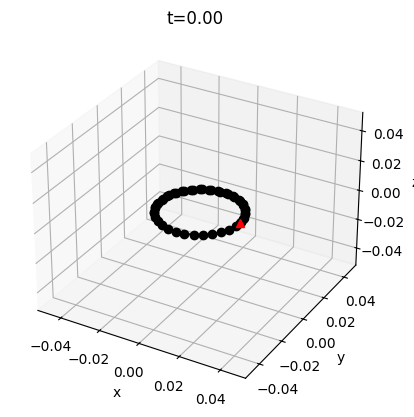

In [147]:
# DOF vector at t = 0
q0 = np.zeros(ndof)
for c in range(nv):
  ind = [4*c, 4*c+1, 4*c+2]
  q0[ind] = nodes[c, :]

u = np.zeros_like(q0) # velocity vector

plotrod_simple(q0, 0)

**Compute the reference (undeformed) length of each edge and the Voronoi length (undeformed) associated with each node**

In [148]:
# Reference (undeformed) length of each edge
refLen = np.zeros(ne)
for c in range(ne): # loop over each edge
  dx = nodes[c+1, :] - nodes[c, :] # edge vector from one node to the next
  refLen[c] = np.linalg.norm(dx)

# Voronoi length of each node
voronoiRefLen = np.zeros(nv)
for c in range(nv): # loop over each node
  if c==0:
    voronoiRefLen[c] = 0.5 * refLen[c]
  elif c==nv-1:
    voronoiRefLen[c] = 0.5 * refLen[c-1]
  else:
    voronoiRefLen[c] = 0.5 * (refLen[c-1] + refLen[c])

**Set up reference frame (a1, a2) and material frame (m1, m2)**

In [149]:
# Reference frame (Space parallel transport at t=0)
a1 = np.zeros((ne,3)) # First reference director
a2 = np.zeros((ne,3)) # Second reference director
tangent = computeTangent(q0) # We need to create this function

t0 = tangent[0,:] # tangent on the first edge
t1 = np.array([0, 0, -1]) # "arbitrary" vector
a1_first = np.cross(t0, t1) # This is perpendicular to tangent t0
# Check for null vector
if np.linalg.norm(a1_first) < 1e-6:
  t1 = np.array([0, 1, 0]) # new arbitrary vector
  a1_first = np.cross(t0, t1)
a1_first = a1_first / np.linalg.norm(a1_first) # Normalize
a1, a2 = computeSpaceParallel(a1_first, q0) # We need to create this function
# a1, a2, tangent all have size (ne,3)

# Material frame
theta = q0[3::4] # twist angles
m1, m2 = computeMaterialFrame(a1, a2, theta) # Compute material frame

**Compute natural curvature, natural twist, and reference twist**
Typically, reference twist and natural twist are both zeros. However, it is not always the case. Natural curvature is zero only if the rod is straight.

In [150]:
# Reference twist
refTwist = np.zeros(nv)
refTwist = getRefTwist(a1, tangent, refTwist) # We need to write this function

# Natural curvature
kappaBar = getKappa(q0, m1, m2) # We need to write this function

# Natural twist
twistBar = np.zeros(nv)

**Set up boundary conditions**
We define the fixed and free DOFs. If the simulation asks that the boundary conditions vary with time (e.g., someone is holding a rod and all on a sudden drops it), we have to define it later within the time stepping loop.

In [151]:
# Fixed and Free DOFs
fixedIndex = np.arange(0,7) # First seven (2 nodes and one edge) are fixed: clamped
freeIndex = np.arange(7,ndof)

**Time stepping loop**

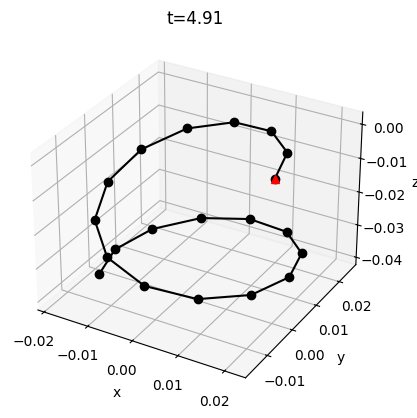

Current time = 4.910000
Iter = 0
Error = 0.000009
Iter = 1
Error = 0.000000
Current time = 4.920000
Iter = 0
Error = 0.000009
Iter = 1
Error = 0.000000
Current time = 4.930000
Iter = 0
Error = 0.000009
Iter = 1
Error = 0.000000
Current time = 4.940000
Iter = 0
Error = 0.000008
Iter = 1
Error = 0.000000
Current time = 4.950000
Iter = 0
Error = 0.000007
Iter = 1
Error = 0.000000
Current time = 4.960000
Iter = 0
Error = 0.000006
Iter = 1
Error = 0.000000
Current time = 4.970000
Iter = 0
Error = 0.000004
Iter = 1
Error = 0.000000
Current time = 4.980000
Iter = 0
Error = 0.000003
Iter = 1
Error = 0.000000
Current time = 4.990000
Iter = 0
Error = 0.000001
Iter = 1
Error = 0.000000


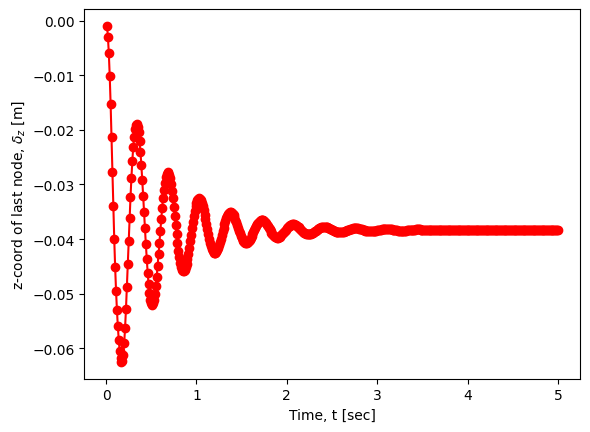

In [114]:
Nsteps = round(totalTime / dt ) # Total number of steps
ctime = 0 # current time
endZ = np.zeros(Nsteps) # Store z-coordinate of the last node with time

for timeStep in range(Nsteps):
  print('Current time = %f' % ctime)

  qGuess = q0.copy() # This should be fixed - I did not include this line in class
  q, u, a1, a2 = objfun( qGuess, # Guess solution
                        q0, u, a1, a2,
                         freeIndex, # Boundary conditions
                         dt, tol, # time stepping parameters
                         refTwist, # We need a guess refTwist to compute the new refTwist
                         massVector, mMat, # Mass vector and mass matrix
                         EA, refLen, # Stretching stiffness and reference length
                         EI, GJ, voronoiRefLen, kappaBar, twistBar, # bending and twisting
                         Fg
                        )

  ctime += dt # Update current time

  # Update q0 with the new q
  q0 = q.copy()

  # Store the z-coordinate of the last node
  endZ[timeStep] = q[-1]

  # Every 100 time steps, update material directors and plot the rod
  if timeStep % 10 == 0:
    plotrod_simple(q, ctime)

# Visualization after the loop
plt.figure(2)
time_array = np.arange(1, Nsteps + 1) * dt
plt.plot(time_array, endZ, 'ro-')
plt.box(True)
plt.xlabel('Time, t [sec]')
plt.ylabel('z-coord of last node, $\\delta_z$ [m]')
plt.show()